# Разбор примера рекомндательной системы

Этот ноутбук - практическое введение в основные методы рекомендательной системы (RecSys). Цель RecSys состоит в том, чтобы рекомендовать пользователям соответствующие товары на основе их предпочтений. Предпочтения и актуальность являются субъективными, и они, как правило, определяются товарами, которые пользователи потребляли ранее.
Основными семействами методов для RecSys являются:

- **Совместная фильтарция на основе памяти (Collaborative Filtering)**
  - **Совместная фильтрация на основе памяти пользователя (User-Base Collaborative Filtering)**: методы позволяющие автоматически прогнозировать (filtering) интересы пользователя, собирая информацию о предпочтениях или вкусах многих пользователей (collaborating). Основное предположение подхода заключается в том, что если у человека A есть то же мнение, что и у человека B по набору предметов, у A больше шансов, чем у случайно выбранного человека, иметь схожее с В мнение в отношении какого-либо предмета.

  - **Совместная фильтрация на основе памяти содержимого (Content-Based Collaborative Filtering)**: методы использующие только информацию об описании и атрибутах элементов (content), которые пользователи ранее использовали, для моделирования пользовательских предпочтений. Другими словами, эти алгоритмы пытаются рекомендовать товары, похожие на те, которые нравились пользователю в прошлом. В частности, различные элементы-кандидаты сравниваются с элементами, ранее оцененными пользователем, и рекомендуются наиболее подходящие элементы.

- **Фильтрация на основе модели (Model-Based  Filtering)**
При таком подходе модели разрабатываются с использованием алгоритмов машинного обучения для прогнозирования оценки пользователем товаров, с которыми он еще не взаимодействовал. Совместная фильтрации на основе памяти, с помощью легкого преобразования становится фильтрацией на основе модели. Ниже мы покажем, как тонка грань между фильтрациями на основе памяти и на основе моделей, а так же, как перейти от одной к другой. 


- **Гибридные методы**
Эти методы сочетают в себе совместную фильтрацию и фильтрацию на основе модели и могут быть использованы для преодоления некоторых распространенных проблем в рекомендательных системах, таких как холодный запуск т.е. при фильтрации на основе памяти, система не может делать какие-либо выводы о пользователях или элементах, о которых она еще не собрала достаточной информации. Также эти методы решают проблему разреженности, когда при совместной фильтрации количество оцененных пользователем объектов гараздо меньше количества объектов.


Реализуюем все эти методы для решения задачи предоставления персонализированных рекомендаций пользователям. Для этого будем использовать датасет MovieLens, который содержит оценки 943 пользователей 1682 фильмов.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
import gc

import xgboost as xgb

!pip install scikit-surprise
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
import scipy.sparse as sp
from scipy.sparse.linalg import svds




     |████████████████████████████████| 11.8 MB 23.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630188 sha256=1c69f77e1a50754306a9cd0566a6f28b5967824a4c2927ce4eab642a53432e53
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
Mounted at /content/gdrive


In [2]:

df = pd.read_csv('data/u.data',  sep='\t', names=['user_id','item_id', 'rating','timestamp'])
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Посмотрим на данные

In [3]:
display(df.isna().sum())
display(df.info())

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


None

С данными все нормально, поэтому разделим их на тренировочные и тестовые

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2)
display(df_train.shape, df_test.shape)

(80000, 4)

(20000, 4)

## Совместная фильтрация на основе памяти (Memory-Based Collaborative Filtering)

### Модель своими руками

Поскольку совместная фильтрация допускает фильтрацию, как на основе пользовательских данных, так и на основе данных о фильмах - попробуем сделать сразу оба варианта и затем сравним их.

Для начала нам нужно привести тренировочный и тестовый датасет к разряженной матрице, где строками будут пользователи, столбцами - фильмы, а на их пересечении будет стоять рейтинг, который выставил пользователь фильму. 

И в тренировочной и в тестовой матрицах матрицах будут потсутствовать все пользователи и все фильмы. Разница будет в том, что в тренировочном датасете, на месте тех "ячеек", что заполнены не нулями в тестовом датасете, будут стоять нули, и наоборот. Т.е. будем оценивать точность модели без учета точности предсказаний по тем фильмам, на которых тренировались. Если же в тестовом датасете будут и тренировочные данные (т.е. тестовый датасет будет менее разрежен по сравнению с тренировочным, потому что в нем будет и тренировочный датасет и новые значения) - ошибка нашей модели, конечно будет поменьше, но мы не сможем точно оценить точность предсказаний.

In [5]:
# получим список всех фильмов
films = df.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).columns

# получим список всех пользователей
users = df.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).index

# получим список фильмов в тренировочном датафрейме
train_films = df_train.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).columns

# получим список всех пользователей в тренировочном датафрейе
train_users = df_train.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).index

# получим список фильмов в тренировочном датафрейме
test_films = df_test.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).columns

# получим список всех пользователей в тренировочном датафрейе
test_users = df_test.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).index

In [6]:
# sparse_matrix_all = df.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0)
sparse_matrix_train = df_train.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0)
sparse_matrix_test = df_test.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0)

train_data_matrix = pd.DataFrame(data = np.zeros((len(users), len(films))), index=users, columns=films)
for i in train_users:
  for j in train_films:
    train_data_matrix.loc[i,j] = sparse_matrix_train.loc[i,j].copy() # sparse_matrix_all.loc[i,j].copy()


test_data_matrix = pd.DataFrame(data = np.zeros((len(users), len(films))),index=users, columns=films)
for i in test_users:
  for j in test_films:
    test_data_matrix.loc[i,j] = sparse_matrix_test.loc[i,j].copy()  # sparse_matrix_all.loc[i,j].copy()


train_data_matrix = train_data_matrix.to_numpy()
test_data_matrix = test_data_matrix.to_numpy()


Убедимся, что мы все сделали правильно и тренировчная и тестовая матрицы у нас различны

In [7]:
np.all(np.isclose(train_data_matrix, test_data_matrix))

False

Теперь нам нужно определить, как мы будем определять "похожесть" объектов (фильмов друг на друга, пользователей друг на друга). Для этого существует масса способов, и именно это явлется первой областью, с которой можно "играться", чтобы достичь наилучших результатов в предсказании.

<br>

Рассмотрим на примере: у нас есть точки $A$(1,2), $B$(2,4), $C$(2.5,4), $D$(4.5,5). Каждая точка - пользователь, а каждая координата точки есть ни что иное, как рейтинг фильма, который выставил пользователь фильму. Графическое представление - ниже.

<br>

Если мы будем определять "похожесть" через евклидово расстояние, то точка $В$ будет значится, как максимально похожая на точку $С$. Это хорошо, но на какую точку больше похожа точка $С$, на $А$ или на $D$? C одной стороны, евклидово расстояние до точки $D$ меньше, но, если мы посмотрим на то, какие оценки первому и второму фильму выставил пользователь $C$, то увидим, что он почти в 2 раза лучше оценил 2 фильм, чем первый. Прямо как пользователь $А$, в то время как пользователь $D$ оценил оба фильма примерно одинаково. Такое поведение уже невозможно отловить евклидовым расстоянием, но можно другими методадми. Например, использовать в качестве меры близости - угол между линиями, соединяющими точки с началом координат. В этом подходе, если угол между векторами возрастает - "похожесть" точек (или в терминах примера - пользователей) - падает.

Для того, чтобы задать "угловую" меру близости нам нужна некоторая функция, которая бы отображал угол. В качестве этой меры может быть использована функция косинуса, которая изменяется в диапазоне от -1 до 1 и может быть удобно применена для оценки "похожести" пользователей. Такой показатель называют "коссинусное сходство" и он считается одним из общепринятых (для рекомендательных систем) коэффицентом меры близости точек. Помимо него, также общеупотребительным является коэффициент корреляции Пирсона. 

<br>

В рамках этого ноутбука, в качестве меры близости, будем использовать именно коссинуссное расстояние.



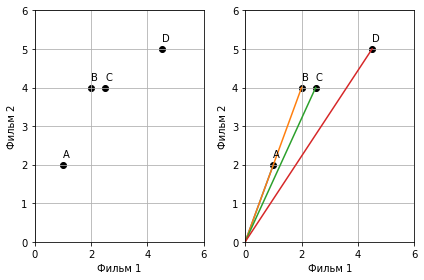

In [8]:
M = np.array([[1,2],[2,4],[2.5,4],[4.5,5]])

plt.rcParams["figure.autolayout"] = True


plt.subplot(1, 2, 1)
plt.scatter(M[:,0],M[:,1], color='black')

plt.text( 1, 2.2,'A')
plt.text( 2, 4.2,'B')
plt.text( 2.5, 4.2,'C')
plt.text( 4.5, 5.2,'D')

plt.grid()
plt.xlim(0,6)
plt.ylim(0,6)
plt.xlabel("Фильм 1")
plt.ylabel("Фильм 2")


plt.subplot(1, 2, 2)
plt.scatter(M[:,0],M[:,1], color='black')

plt.plot([0, M[0][0]],[0,M[0][1]])
plt.plot([0, M[1][0]],[0, M[1][1]])
plt.plot([0, M[2][0]],[0, M[2][1]])
plt.plot([0, M[3][0]],[0, M[3][1]])

plt.text( 1, 2.2,'A')
plt.text( 2, 4.2,'B')
plt.text( 2.5, 4.2,'C')
plt.text( 4.5, 5.2,'D')

plt.grid()
plt.xlim(0,6)
plt.ylim(0,6)
plt.xlabel("Фильм 1")
plt.ylabel("Фильм 2")


plt.show()


Стоит также отметить, что, с точки зрения коссинусного сходства, пользователи $A$ и $B$ считаются абсолютно одинаковыми, даже несмотря на то, что они выставили разные оценки одним и тем же фильмам. На самом деле это обычное явление в реальном мире, и таких как пользователь $А$, называют "жесткими оценщиками". Однин из примеров "жестких оценщиков" - кинокритик, который всегда выдает оценки ниже среднего, но если упорядочить фильмы, которые он оценил по рейтингу, который он выставил - порядок не будет отличаться от порядка менее сурового оценщика, который с точки зрения коссинусосного сходства такой же как "жесткий оценщик".

Посчитаем матрицы коссинусных расстояний (т.е. коэффиценты "похожести") пользователей и фильмов.


In [9]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

После этого, мы уже можем делать какие-то прогнозы. 

Для фильтрации основанной на пользователях - мы должны использовать следующую формулу:

$\hat{x}_{k,m} = 
  \bar{x}_k+
  \frac{
        \sum_{u_a}sim_u(u_k , u_a)
          (
            x_{a,m}-\bar{x_{u_a}}
          ) 
        }
        {
        \sum{|sim_u(u_k,u_a)|
        }
}$



В то время, как для фильтрации основанной на фильмах:
$\hat{x}_{k,m} = \frac{
                      \sum_{i_b}sim_i(i_m,i_b)(x_{k,b})
                      }
                      {
                        \sum{|sim_i(i_m,i_b)|
                      }
}$

Эта разница в подходах обусловленна тем, что при фильтрации на основе пользователей есть проблема, что некоторые пользователи могут всегда давать высокие или низкие оценки всем фильмам. Относительная разница в оценках, которые дают эти пользователи, более важна, чем абсолютные значения рейтинга. Например, один пользователь дает 4 звезды своим любимым фильмам и 3 звезды всем другим хорошим фильмам, а другой пользователь оценивает фильмы, которые ему нравятся, на 5 звезд, а фильмы, на которых он уснул, на 3 звезды. У этих двух пользователей могут быть очень похожие вкусы, но они по разному относятся к рейтинговой системе.

При фильтрации на основе данных о фильмах такой проблемы нет, потому как для постртоения прогноза нет субъективизации в оценке.

**N.B.:** поскольку у нас есть проблема "жестких оценщиков" - приведем оценки пользователей к единой шкале. Вычтем из всех оценок пользователя среднее значение его оценок, при этом нужно не забыть сделать обратное преобразование, при получении прогноза.

In [10]:

def predict(ratings, similarity, type):
  if type == 'user':
    
    # посчитаем средний рейтинг, по каждому пользователю
    mean_user_rating = ratings.mean(axis=1)
    
    # сделаем некоторую нормировку рейтингов, которые пользователь выставлял 
    # таким образом мы приведем их к одному масштабу
    ratings_diff = (ratings - mean_user_rating[:,np.newaxis])

    pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T

  elif type == 'item':
    pred = ratings.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
  
  return pred

item_pred = predict(train_data_matrix, item_similarity, 'item')
user_pred = predict(train_data_matrix, user_similarity, 'user')

На самом деле - все. Мы прошли полный цикл и предсказали рейтинги каждого фильма, выставленные каждым пользователем, на основе тренировочных данных. Причем сделали это двумя разными метотади: совместной фильтрацией пользователей и совместной фильтрацией фильмов.

Но прежде чем предсказывать - нужно оценить,  насколько хорошо мы предсказали. Мы точно можем оценить, насколько удачно мы спрогнозировали рейтинги тех фильмов, которые пользователь уже посмотрел.

**N.B.:** чтобы у нас не было завышения ошибки из-за того, что мы предсказали, какой рейтинг пользователь поставит для фильма, а пользователь не посмотрел фильм - оценивать будем только по просмотренным.

In [11]:


def rmse(pred, real):
  pred = pred[real.nonzero()].flatten().copy()
  real = real[real.nonzero()].flatten().copy()
  return mean_squared_error(pred, real)**(1/2)


print('rmse совместной фильтрации пользователей:',rmse(user_pred, test_data_matrix))
print('rmse совместной фильтрации фильмов:',rmse(item_pred, test_data_matrix))

rmse совместной фильтрации пользователей: 3.0888299261952774
rmse совместной фильтрации фильмов: 3.439027787230947


Получили какие-то результаты. Теперь нужно понять, а это вообще нормальные результаты или нет. Сравним полученный RMSE с RMSE "средней" модели, т.е. когда мы просто говорим, что пользователь поставит фильму свою среднюю оценку.



**N.B.1:** "при выборе User/User или Item/Item необходимо учитывать кого больше — пользователей или фильмов. Если больше пользователей, то предпочтительнее Item/Item, если наоборот - User/User". Именно это утверждение подкрепляется полученными результатами (у нас 943 пользователя и 1682 фильма) 

**N.B.2:** обычно, ввиду динамической природы данных о пользователях, предпочтительнее использовать Item/Item подход. Это позволяет реже переобучать модель и легче масштабировать решение (предпочтения пользователей меняется куда более динамично, чем средняя оценка фильма).

In [12]:
baseline_matrix = np.zeros(train_data_matrix.shape)
means_per_user = np.mean(train_data_matrix, axis=1)

for i in range(0, baseline_matrix.shape[0]):
  baseline_matrix[i] = means_per_user[i]

print('rmse baseline:',rmse(baseline_matrix, test_data_matrix))

rmse baseline: 3.4029508576257363


В целом, модель совместной фильтрации на основании памяти о пользователях работает лучше чем прогноз по среднему. Это значит, что мы движемся в правильном направлении. 

Теперь, зная как наша модель работает, посмотрим как сделать топ-N рекомендаций. Допустим мы хотим получить 5 наиболее подходящих фильма для 3 пользователя.


In [13]:
res = pd.DataFrame(user_pred, index=users, columns=films)
res.head(5)

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.698428,0.597889,0.532603,0.841038,0.531352,0.387941,1.483942,0.986896,1.247450,0.565430,...,0.320178,0.317044,0.317044,0.319009,0.319664,0.317044,0.320921,0.317044,0.317044,0.319215
2,1.401956,0.275457,0.163804,0.557197,0.174366,-0.005312,1.202902,0.701347,0.913174,0.195438,...,-0.080105,-0.083351,-0.083351,-0.081189,-0.080299,-0.083351,-0.080627,-0.083351,-0.083351,-0.080029
3,1.431978,0.241655,0.137371,0.524597,0.141864,-0.033294,1.204010,0.674162,0.910952,0.169231,...,-0.112251,-0.115649,-0.115649,-0.113805,-0.112578,-0.115649,-0.113428,-0.115649,-0.115649,-0.112335
4,1.405851,0.224982,0.122193,0.504837,0.124372,-0.046018,1.183849,0.656028,0.899629,0.158239,...,-0.125335,-0.128537,-0.128537,-0.126468,-0.125566,-0.128537,-0.125984,-0.128537,-0.128537,-0.125213
5,1.467329,0.355425,0.292258,0.613993,0.287111,0.143488,1.275575,0.758119,1.043747,0.327500,...,0.066630,0.063512,0.063512,0.065644,0.066581,0.063512,0.067203,0.063512,0.063512,0.066247


In [14]:
user_id = 3
n_top = 5

# возьмем все предсказания для нашего пользователя относительно всех фильмов
all_films_for_user = df_train.pivot_table(index='user_id',columns='item_id',values='rating').fillna(0).loc[user_id,:]

# выберем те фильмы, которые он уже смотрел и оценил
seen_films_for_user = all_films_for_user[all_films_for_user>0].index

# посоветуем пользователю фильмы, которые он еще не смотрел, но которые могут ему подойти
recomends = res.loc[user_id,list(set(res.loc[user_id,:].index) -set(seen_films_for_user))].T.sort_values(ascending=False).head(n_top).index.to_list()

print(f'пользователю с user_id={user_id} наилучшим образом подойдут фильмы с item_id: {", ".join(map(str, recomends))}')

пользователю с user_id=3 наилучшим образом подойдут фильмы с item_id: 50, 100, 174, 1, 127


Как мы показали выше - модель не достаточно хорошо рекомендует. Но попробуем ее улучшить. Сделать это можно несколькими способами: 
- добавить новых признаков, как для пользователей (соц.дем. характеристики, поведенческие паттерны), так и для фильмов ( жанр, актеры, год выпуска)
- провести кластеризацию пользователей и фильмов (т.е. разбить выборки на группы) и уже потом расчитывать матрицы внутри каждого кластера. Так можно увеличить точность определения "похожести" пользователей и "похожести" фильмов между собой и сможем более точно рекомендовать
- использовать оба описанных подхода вместе.


Попробуем расчитывать коссинусные сходства внутри ближайших соседей (читай - кластеров). Это уже можно будет считать фильтрацией на основе модели, потому как мы будем использовать алгоритм кластеризации.

### Модель с помощью библиотек


Попробуем проделать все тоже самое, но с помощью библиотеки. 
В этом блоке мы несколько изменим алгоритм расчета предсказаний, будем использовать следующую формулу:

$\hat{x}_{u,i} = 
  \bar{x}_u+
  \frac{
        \sum_{v \in N_i^k(u)}sim(u , v)
          (
            x_{v,i}-\bar{x_{v}}
          ) 
        }
        {
        \sum_{v \in N_i^k(u)}{sim(u,v)
        }
}$

где 
- $k$-количество "похожих" пользователей
- $N_i^k(u)$ - включает в себя только тех соседей, с которыми коэффициент "похожести" положителен.

Основная идея метода заключается в том, что для заданого пользователя $u$, который еще не оценил фильм $i$ (а значит не смотрел его), мы ищем к-наиболее похожих на $u$ пользователей, которые смотрели теже фильмы, что и $u$, а также фильм $i$.Эти к-людей составляют вектор $v$ и он составляется только из тех людей, косиннусное сходство с которыми не отрицательно. Ожидаемый рейтинг, который выставит пользователь $u$ фильму $i$, есть ни что иное как средний рейтинг к-наиболее похожих на $u$ пользователей.


**N.B.:** метод ближайщих соседей имеет квадратичную сложность $O(n^2,m)$ где $n$-число пользователей, а $m$-число фильмов, что делает его не очень приминемым в реальной жизни.

In [15]:
# подгрузим наш датасет в необходимый библиотеке формат
# класс Reader ожидает, что данные будут в следующем порядке: пользователь-фильм-рейтинг
# у нас как раз этот порядок

data_train = Dataset.load_from_df(df_train.drop(columns='timestamp'), Reader())

# определим, что пойдем "от пользователей" 
# и в качестве меры "похожести" будем использовать косинусное сходство

sim_options = {
    "name": 'cosine',
    "user_based": True, 
}

# зададим алгоритм

algo = KNNWithMeans(sim_options=sim_options)

# опеределим, что тренировать мы будем на всем датасете (он ведь у нас тестовый)
# и натренируем алгоритм

trainingSet = data_train.build_full_trainset()
algo.fit(trainingSet)


# спрогнозируем оценки пользователя для каждого фильма
pred = []
for idx, values in df_test.iterrows():
  u_id = str(values['user_id'])
  i_id = str(values['item_id'])
  pred.append(algo.predict(u_id,i_id).est)

# проверим нашу точность
print('rmse совместной фильтрации пользователей:',mean_squared_error(pred, df_test.rating)**(1/2))

Computing the cosine similarity matrix...
Done computing similarity matrix.
rmse совместной фильтрации пользователей: 1.1279527882407134


Как видно - кластеризациея пользователей, дает свои плоды и, ошибка предсказаний уменьшилась в 3 раза.

<br>

В целом, можно попробовать еще снизить ошибку предсказания путем задания совственной меры (того самого "приведенного коссинусного сходства"), и даже еще больше улучшить модель, например, подбирая параметры кластеризации. Но мы двинемся дальше и разберемся, как нам исправить основую проблему метода совместной фильтрации на основе памяти. А именно, что эти методы достаточно требователены к вычеслительным ресурсам, ввиду наличия большой по размерности разреженной матрицы пользователь-фильм. На наших данных - проблема размерности не так четко видна, как, например у маркетплейса с миллионами пользователей и товаров.  Чтобы обойти данную проблему, обычно, в реальной жизни, вместо метода на основе памяти используют метод на основе модели.


## Фильтрация на основе модели (Model-Based Filtering)

Суть данных методов заключается в  представлении пользователей и элементов в скрытом пространстве более низкого измерения. Алгоритмы факторизации матриц раскладывают матрицу взаимодейстия пользовател и фильма (та самая, разряженная матрица), как произведение двух прямоугольных матриц меньшей размерности.
Т.е. $M=XY$ где 
- $M$- наша разреженная матрица, размерности $(users \times items)$
- $X$- матрица пользователей, размерности $(users \times p)$ 
- $Y$- матрица фильмов размерности $(p \times items) $

### Модель своими руками

#### На основе разложения матриц градиентным спуском ###

Одним из методов фильтрации на основе модели является метод разложения матриц с помощью градиентного спуска, при котором разряженная матрица $R$ аппроксимируется как: $R = P \times Q^T$

где 
- $P$ матрица размерности $(u \times k)$ 
- $Q$ матрица размерности $(i \times k)$
- $u$ и $i$ - количество пользователей и фильмов, соответственно, в нашей разреженной матрице (т.е. кол-во строки и столбцов).



**Основной алгоритм**:

В полученном разложении элементы матрица с пердсказаниями будет вычисляться как:
$\hat r_{i,j}=p_i^Tq_j=\sum_{k=1}^kp_{i,k}q_{k,j}$

А ошибки предсказаний того, как каждый пользователь оценит каждый фильм: 
$e_{i,j}^2 = (r_{i,j}-\hat r_{i,j})^2 = (r_{i,j}-\sum_{k=1}^Kp_{i,k}q_{k,j})^2 $

Теперь, нам нужно понять, в каком направлении делать спуск. Логично, что в направлении обратном направлению возрастания ошибки. Т.е. в направлении обратном градиенту $e_{i,j}^2$. А вспомнив, что градиент есть ни что иное, как вектор чатных производных - можем найти  $(e_{i,j}^2)'$, по каждой из компонент $p_{i,k}$ и $q_{k,j}$: 

- $(e_{i,j}^2)'_{p_{i,k}} = -2(r_{i,j}-\hat r_{i,j})(q_{k,j}) = -2e_{i,j}q_{k,j}$
- $(e_{i,j}^2)'_{q_{i,k}} = -2(r_{i,j}-\hat r_{i,j})(p_{k,j}) = -2e_{i,j}p_{i,k}$

Тогда движение по направлению обратного градиента:

- $p_{i,k}' = p_{i,k} + 2 \alpha e_{i,j}q_{k,j}$
- $q_{k,j}' = q_{k,j} + 2 \alpha e_{i,j}p_{i,k}$

Где $\alpha$ - размер шага (learning rate)

А обновление элементов должно происходить, пока общая ошибка, вычисляемая по формуле
$E=\sum_{(u_i,d_j,r_{i,j})\in T}e_{i,j} = \sum_{(u_i,d_j,r_{i,j})\in T}(r_{i,j}- \sum_{k=1}^Kp_{i,k}q_{k,j})^2$
 
не будет меньше какой-то, заранее заданной, достаточно малой $\epsilon$ 


**Дополнения к основному алгоритму:**

Существует также множество расширений для этого алгоритма, которые позволяют избежать переобучения и увеличить скорость "сходимости". Одним из этих методов является регуляризация.

*N.B.: если алгоритм не сходится, т.е. ошибка от итерации к итерации только растет - значит задали слишком большой learning_rate.*

**Дополнение 1**

Самым простым методом регуляризации является добавление в функцию ошибки параметра, который будет регулировать скорость спуска - $\beta$ (или momentum):

$e_{i,j}^2 = (r_{i,j}-\sum_{k=1}^Kp_{i,k}q_{k,j})^2+\frac{\beta}{2}\sum_{k=1}^K(\|P\|^2+\|Q\|^2) $

Тогда движение по направлению обратного градиента принимает вид:

- $p_{i,k}' = p_{i,k} + \alpha (2e_{i,j}q_{k,j}-\beta p_{i,k})$
- $q_{k,j}' = q_{k,j} + \alpha (2e_{i,j}p_{i,k} - \beta q_{k,j})$

**Дополнение 2**

Кроме того, мы бы хотели, чтобы наша модель обучалась как можно быстрее, без потери точности. Для этого, например, можно 
- на первых шагах использовать большой размер шага ($\alpha $ или learning rate), а затем, постепенно его снижать, дабы не проскочить точку минимума. Этот метод называется методом "отжига". Будем сжигать по 10% от learning rate на каждом шаге (т.е. каждый следующий шаг будет на 10% короче предыдущего). 
- изменять скорость спуска ($\beta $ или momentum).

Тогда движение по направлению обратного градиента принимает вид:

- $p_{i,k}' = p_{i,k} - \alpha *velocity^p_{i,k} $
- $q_{k,j}' = q_{k,k}- \alpha * velocity^q_{k,j} $

Где матрицы $velocity^p$ и $velocity^q$, на начальном этапе - нулевые матрицы размерностью как $P$ и $Q$. На последующих этапах элементы этой матрицы обновляются по следующим законам:

- $velocity^p_{i,k} = (1-\beta)*velocity^p_{i,k}+\beta* grad_{p_{i,k}} = (1-\beta)*velocity^p_{i,k}+\beta* (-2e_{i,j}q_{k,j})$


- $velocity^q_{k,j} = (1-\beta)*velocity^q_{k,j}+\beta*grad_{q_{k,j}} = (1-\beta)*velocity^q_{k,j}+\beta* (-2e_{i,j}p_{i,k})) $

<br>

Подобный (хотя и более сложный) метод факторизации используется в Facebook (признано экстремистской организацией на территории РФ).

**N.B.:** при прогнозировании на основе памяти, в самописном варианте мы решали проблему "жестких оценщиков" непосредственно в функции прогнозированя (в user base части). Мы вычетали из всех оценок пользователя среднее значение его оценок, приводя тем самым оценки всех пользователей к единой шкале. В случае градиентного спуска, чтобы решить эту же проблему - сделаем предварительное преобразования тренировочных данных, при этом нужно не забыть сделать обратное преобразование, при получении прогноза.

In [16]:
arr_mean=[]
scaled_train_data_matrix = train_data_matrix.copy()

for i in range(train_data_matrix.shape[0]):
  mean = train_data_matrix[i].mean()
  scaled_train_data_matrix[i] = train_data_matrix[i] - mean
  arr_mean.append(mean)

А теперь - опишем градиентный спуск

In [17]:
def matrix_factorization(R,P,Q,K, steps = 50, learning_rate = 1e-8, momentum = 0.015):
  # будем делать всего steps шагов спуска, каждый шаг у нас будет длинной в learning_rate
  # R примерно P x Q.T, где P- матрица размерности кол-во польхователей на k и Q - матрица размерности фильмов на k 
  
  Q = Q.T
  cnt_users = R.shape[0]
  cnt_films = R.shape[1]
  
  velocity_p = np.zeros_like(P)
  velocity_q = np.zeros_like(Q)


  for step in range(steps):                                                             # на каждом шаге
    for i in range (cnt_users):                                                         # для каждого пользователя
      for j in range(cnt_films):                                                        # для каждой оценки контретного пользователя конкретного фильма

        if R[i][j]>0:                                                                   # если реальный рейтинг есть - считаем ошибку 
          eij = R[i][j]-np.dot(P[i,:],Q[:,j])   

          for k in range(K):                                                            # и обновляем матрицы

            # P[i][k] = P[i][k] + learning_rate*(2*eij*Q[k][j]-momentum*P[i][k])
            # Q[k][j] = Q[k][j] + learning_rate*(2*eij*P[i][k]-momentum*Q[k][j])
            
            P[i][k] -= learning_rate*velocity_p[i][k]                                   # сначала расчитаем новые коэффицент матрицы P
            velocity_p[i][k] = (1-momentum)*velocity_p[i][k]+momentum*(-2*eij*Q[k][j])  # затем изменим скорость спуска

            Q[k][j] -= learning_rate * velocity_q[k][j]                                 # сначала расчитаем новые коэффицент матрицы Q
            velocity_q[k][j]=(1-momentum)*velocity_q[k][j]+momentum*(-2*eij*P[i][k])    # затем изменим скорость спуска

        
    
    e = 0                                                                               # теперь посчитаем ошибку полученной аппроксимированной матрицы

    for i in range(cnt_users):                                                          # для каждого пользователя    
      for j in range(cnt_films):                                                        # для каждой оценки контретного пользователя конкретного фильма 
        if R[i][j]>0:                                                                   # если реальный рейтинг есть - считаем ошибку 
          e = e+ ((R[i][j]-np.dot(P[i,:],Q[:,j]))**2)                       

          for k in range(K):                                                            # не забудем пересчитать ошибку с учетом скорости спуска
            e = e+(momentum/2)*(P[i][k])**2+(Q[k][j])**2                    

    if e < 0.001:
      break

    learning_rate = 0.90*learning_rate                                                  # "отожжом" наш размер шага 
  return P, Q.T

K = 15
P = np.random.rand(scaled_train_data_matrix.shape[0], K)
Q = np.random.rand(scaled_train_data_matrix.shape[1], K)

pred_P, pred_Q = matrix_factorization(scaled_train_data_matrix, P, Q, K)

pred = np.dot(pred_P, pred_Q.T)

# сделаем обратное маштабирование данных
for i in range(pred.shape[0]):
  pred[i]=pred[i]+arr_mean[i]


print(f'rmse совместной фильтрации на основе модели:{mean_squared_error(pred[test_data_matrix.nonzero()].flatten(), test_data_matrix[test_data_matrix.nonzero()].flatten())**(1/2)}')


rmse совместной фильтрации на основе модели:1.5289038548084457


Покажем, как теперь можно предсказывать рейтинг конкретного фильма для конкретного пользователя. Например, мы знаем, что в тестовых данных у нас информация, что 1 пользователь (строка с индексом 0 в тестовых данных, потому что нумерация начинается с нуля) оценил 14 фильм (13 столбец, потому что нумерация с нуля) в 5 баллов из 5. Проверим, сколько баллов предскажет наша модель

In [52]:
test_data_matrix[0,13]

5.0

In [53]:
user_id = 0
film_id = 13
np.dot(pred_P[user_id],pred_Q[film_id].T)+arr_mean[user_id]

4.5897693865584595

В целом - результат не так уж и ужасен. Нам удалось побить результат самописной фильтрации на основе памяти. Однако, еще есть куда стремится и можно попытаться улучшить, например, подбирать параметры $\alpha$ и $\beta$, а также менять количество шагов и изменять коэффициент отжига.

Можно проделать, тот же самый градиентный спуск с помощью библиотеки, но мы посмотрим на еще один способ разложения матриц (градиентный спуск на основе библиотеки мы используем позднее, когда будем изпользовать градиентный бустинг над решающим лесом).

Напомним, что в методе совместной фильтрации на основе памяти есть проблема наличия большой разряженной матрицы. Проблема наличия этой матрицы заключается в том, что если у нас миллионы пользователей и тысячи фильмов, то чтобы сделать рекомендацию для конкретного пользователя - нам нужно взять всю матрицу, найти в ней пользователя и только после этого взять прогнозные рейтинги и выбрать из них. Кроме того, хранение такой матрицы тоже само по себе достаточно "дорогое" удовольствие (с точки зрения памяти).
 
Что если мы будем "на ходу" прогнозировать рейтинги, а не искать их?

#### На основе сингулярного разложения матриц ###

В этом методе, разряженная матрица $M$ аппроксимируется матричным перемножением трех матриц: $X$, $Y$ и $S$, где $S$ - диагональная матрица размерности $(p \times p)$ с не отрицательными вещественными значениями на главной диагонали.
Т.е. $M=XSY$, или, если говорить в терминах, которые мы использовали ранее (при описании совместной фильтрации на основе памяти): $X=USV^T$.

Именно такой метод использует Netflix в своих рекомендательных системах.


**N.B.:** как и прежде, существует необходимость решать проблему "жестких оценщиков". Делать это будем как и раньше - вычитая из всех оценок пользователя среднее значение его оценок. При этом, как и раньше, важно не забыть добавить это значение к прогнозным данным, чтобы привести прогноз к исходному масштабу. Также, для увеличения точности, можно прибегнуть к модели, когда итоговый рейтинг есть улучшение некого "базового" рейтинга, который, для каждой оценки конкретного фильма конкретным пользователем, считается как:
$\hat r_{u,i} = r_{total\_mean} + r_{u\_mean} +r_{i\_mean}$

где 
- $r_{total\_mean}$ средняя оценка всех пользователей всех фильмов
- $ r_{u\_mean}$ средняя оценка, которую выставляет конкретный пользователь всем фильмам
- $r_{i\_mean}$ средняя оценка конкретного фильма по всем пользователям

In [20]:

arr_mean_user=[]
arr_mean_item=[]

scaled_1_train_data_matrix = train_data_matrix.copy()

for i in range(train_data_matrix.shape[0]):
  mean_user = train_data_matrix[i,:].mean()
  scaled_1_train_data_matrix[i] = train_data_matrix[i] - mean_user
  arr_mean_user.append(mean_user)

scaled_1_train_data_matrix = scaled_1_train_data_matrix.T

for j in range(train_data_matrix.shape[1]):
  mean_item = train_data_matrix[:,j].mean()
  scaled_1_train_data_matrix[j] =  train_data_matrix.T[j] - mean_item
  arr_mean_item.append(mean_item)

scaled_1_train_data_matrix = scaled_1_train_data_matrix.T


In [21]:
u,s,v = svds(scaled_1_train_data_matrix, k =min(scaled_1_train_data_matrix.shape)-1)
s_diag = np.diag(s)

# посмотрим на результаты аппроксимации
pred = np.dot(np.dot(u,s_diag),v)

print(f'rmse разложения относительно исходной матрицы:{rmse(pred, scaled_1_train_data_matrix)}')


rmse разложения относительно исходной матрицы:3.717723649372291e-15


Получив аппроксимацию нашей разряженной матрицы, мы значительно снизили ресурсы, которые нужны для вычислений.

Соответственно - можем быстрее прогнозировать. Более того, поскольку теперь, при прогнозировании учитываеются сразу и фильмы и пользователи - прогноз должен стать точнее относительно метода совместной фильтрафии на основе памяти.

Как понятно из формул сингулярного разложения матриц, чтобы спрогнозировать элемент $\hat r_{u,i}$ (т.е. рейтинг, который выставит конкретный пользователь конкретному фильму) нам нужно матрично перемножить $r_u \times r_i $ и прибавить полученное к "базовому" прогнозу.


In [22]:
def predict(u, v, mean_users, mean_items, mean_total ):

  mean_users = np.array(mean_users)[:,np.newaxis]
  mean_items = np.array(mean_items)[np.newaxis,:]
    

  # рассчитаем прогнозный рейтинг, как базовый рейтинг фильма
  # (срдений общий рейтинг+средний рейтинг пользователя+средний рейтинг фильма)
  # и затем добавим рейтинг, который ожидается из разложения
  pred = mean_total + mean_users+mean_items + np.dot(u,v)

  return pred

pred = predict(u, v, arr_mean_user, arr_mean_item, train_data_matrix[train_data_matrix.nonzero()].mean())


print('rmse совместной фильтрации на основе модели:',rmse(pred, test_data_matrix))

rmse совместной фильтрации на основе модели: 1.386130278354756


Аналогично методу градиентного бустинга, можно отдельно рассчитать рейтинг, который выставит конкретный пользователь конкретному фильму.

In [51]:
user_id = 0
film_id = 13
print(f'предсказанный рейтинг: {train_data_matrix[train_data_matrix.nonzero()].mean() + arr_mean_user[user_id]+arr_mean_item[film_id] + np.dot(u[user_id],v.T[film_id])}')
print(f'реальный рейтинг {test_data_matrix[user_id,film_id]}')

предсказанный рейтинг: 4.5848248078725184
реальный рейтинг 5.0



В целом, рекомендательная система, с помощью  фильтрации на основе модели показывает результаты лучше совместной фильтрацией на основе памяти (если мы сравниваем самописные варианты), требуя при этом гараздо меньше ресурсов (особо ощущается на реальных задачах, когда разряженная матрица имеет размерность "несколько миллионов пользователей $\times$ десятки тысяч фильмов").

Кроме того, при использовании сингулярного разложения мы также показали, как можно "победить" проблему холодного старта (в целом, аналогичный подход можно применить и для градиентного спуска). В случае, если пользователь у нас новый и по нему еще нет никакой истории, он все равно получит какие-то фильмы в рекомендации, в силу того, что рейтинг, который выставляет пользователь фильму, уже является не монолитным и состоит из 3х частей: средний общий рейтинг фильмов на платформе, средний рейтинг конкретного фильма на платформе и средняя оценка фильмов конкретным пользователе. И вот только в последнем у нового пользователя не будет данных.

## Гибридные модели

Также, как и все методы машиного обучения, модели рекомендательных систем можно объединять. Обычно такие подходы позволяют нивелировать ошибки одних методов более точными предсказаниями других, что в итоге дает прирост точности "объединенной" модели над каждой из ее составляющей оцененной по отдельности.

Самыми распространенными методами объединения моделй являются: 
- взвешивание (weighting)
- переключение (switching)
- смешивание (mixinig)
- комбинирование признаков (feature combinating)
- расширение признаков (feature augmentation)
- каскад (cascade)
- meta-level

Рассмотрим взвешивание. 

По большому счету это создание такой верхнеуровневой модели, предсказания которой получаются из суммы произведений предсказаний моделей более низкого уровня на какие-то коэффициенты. Да, в примитивном случае, в качестве верхнеуровневой модели может выступать обычная линейная регрессия.

Поскольку у нас уже есть модель (сигулярное разложение), а также нам бы хотелось использовать дополнительные данные о пользователях и фильмах, то  попробуем использовать сингулярное разложение и бустинг над случайным лесом с использованием дополнительных данных о пользователях и фильмах.

Сделаем модель для бустинга над случайным лесом. Т.е., де-факто сведем задачу рекомендаций к задаче многофакторной регрессии (коей она и является, по большому счету).

**N.B.:** в теории, при сингулярном разложении можно было также использовать множество факторов, с той лишь разницей, что у нас на вход подавалась бы не двумерная матрица user/item, а 4х мерный тензор (добавились бы признаки фильмов и признаки пользователей)

Для начала загрузим данные о пользователях

In [24]:
user = pd.read_csv('data/u.user', delimiter = '|', names = ['id', 'age', 'gender', 'occupation', 'zip'], usecols = ['id', 'age', 'gender', 'occupation'] )
user.head()

,id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


Ранее мы самостоятельно делили выборку на тренировчную и тестовую. 
А раз так, то может случиться, что в обучающую выборку попадут не все данные, тогда, мы не можем, например брать все элементы из "occupation" тренировочного датасета user и говорить, что в тестовом датасете нет других элементов. Поэтому, лучше все-же брать все возможные значения поля "occupation" из другого места.

In [25]:
 occupation_cols = pd.read_csv('data/u.occupation', delimiter = '|', names = ['occupation'])['occupation'].to_list()
 occupation_cols

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

Теперь нам нужно закодировать все места работы пользователей и их пол.

In [26]:
user[occupation_cols] = OneHotEncoder(sparse=False).fit_transform(user.occupation.to_numpy().reshape(-1,1))
user['gender'] = LabelEncoder().fit_transform(user.gender)
user = user.drop(['occupation'], axis = 1)
user

,id,age,gender,administrator,artist,doctor,educator,engineer,entertainment,executive,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,1,24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,53,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,33,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
939,940,32,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,941,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
941,942,48,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


И можно присоединить эту информацию к уже имеющейся информации о том, как пользователь оценил фильм

In [27]:
x_train = df_train[['user_id', 'item_id']].join(user.set_index('id'), on='user_id')
x_test = df_test[['user_id', 'item_id']].join(user.set_index('id'), on='user_id')
x_train.head()

,user_id,item_id,age,gender,administrator,artist,doctor,educator,engineer,entertainment,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
68927,393,141,19,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5142,100,302,36,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11065,201,443,27,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38677,450,430,35,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84394,864,993,27,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Проделаем подобное и для фильмов

In [28]:
genre = pd.read_csv('data/u.genre', delimiter = '|', names = ['genre', 'id'])['genre'].to_list()
genre

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [29]:
item_col_names = ['movie id','movie title','release date','video release date','IMDb URL'] + genre

item = pd.read_csv('data/u.item', delimiter = '|', names = item_col_names, encoding = 'latin1')
item = item [['movie id']+genre]
item

,movie id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
x_train = x_train.join(item.set_index('movie id'), on='item_id')
x_test = x_test.join(item.set_index('movie id'), on='item_id')
x_train.head()

,user_id,item_id,age,gender,administrator,artist,doctor,educator,engineer,entertainment,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
68927,393,141,19,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
5142,100,302,36,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
11065,201,443,27,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
38677,450,430,35,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
84394,864,993,27,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


Теперь нам бы хотелось все-же увидеть рейтинги.

In [31]:


y_train = df[['user_id','item_id','rating']].copy()

x_train = x_train.join(y_train.set_index(['user_id','item_id']), on=['user_id','item_id'])
y_train = x_train.rating.copy()
x_train = x_train.drop(columns='rating')




y_test = df[['user_id','item_id','rating']].copy()

x_test = x_test.join(y_test.set_index(['user_id','item_id']), on=['user_id','item_id'])
y_test = x_test.rating.copy()
x_test = x_test.drop(columns='rating')

Ну а теперь мы можем попробовать прогнозировать рейтинг, который пользователь выставит фильму, основываясь на информации о пользователе и информации о фильме

In [32]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(x_train, y_train)

pred_1 = model.predict(x_test)
rmse = np.sqrt(np.mean((pred_1 - y_test.to_numpy())**2))
print(f'rmse модели на основе совместной фильтрации: {rmse}')

rmse модели на основе совместной фильтрации: 1.0436948230786385


Отлично. Мы натренировали первую модель и у нас есть предсказания для тестового датасета

In [33]:
res = x_test[['user_id','item_id']].copy()
res['rating'] = y_test.copy() 
res['pred_1'] = pred_1
res

,user_id,item_id,rating,pred_1
84789,614,235,5,3.411972
70573,848,603,5,3.786823
57862,798,367,3,3.264571
99373,398,1,5,3.727563
67441,745,204,3,3.587713
...,...,...,...,...
31054,62,44,3,3.898228
90925,497,42,4,3.556968
83768,749,393,5,3.230222
22863,311,768,2,3.061135


Теперь сделаем предсказания методом сингулярного разложения. Поскольку у нас тренировочный и тестовый датасеты остались теже, то не будем переписывать, просто возьмем уже готовые предсказания.

In [34]:
pred_2 = pd.DataFrame(pred, index=users, columns=films).melt(var_name = 'item_id', value_name ='rating', ignore_index=False).reset_index()

In [35]:

res = res.join(pred_2.set_index(['user_id','item_id']).rename(columns={'rating':'pred_2'}), on=['user_id','item_id'],how='left').fillna(0)
res

,user_id,item_id,rating,pred_1,pred_2
84789,614,235,5,3.411972,4.049185
70573,848,603,5,3.786823,4.550739
57862,798,367,3,3.264571,4.362608
99373,398,1,5,3.727563,5.294841
67441,745,204,3,3.587713,4.813564
...,...,...,...,...,...
31054,62,44,3,3.898228,4.050518
90925,497,42,4,3.556968,4.400740
83768,749,393,5,3.230222,4.542962
22863,311,768,2,3.061135,4.138717


Теперь у нас есть предсказания двух моделей, можем их взвешивать, считать ошибку и, вес при котором ошибка будет минимальной - будет идеальным. По сути -  у нас есть задача линейной регрессии.
$\hat r_{final} = w_1x_1+w_2x_2+const$ где $ x_i \, i=\overline {1,2}$ - предсказания первой и второй модели
 Так и будем ее решать линейной регрессией. 
 Проблема заключается в том, что нам не с чем сравнивать и нет независимых переменных, на которых можем тренировать модель. Поэтому, разделим нашу тестовую выборку на две: тренировочнуи и тестовую. И уже на ней посмотрим, получили ли мы улучшение качества модели

In [36]:
meta_x_train, meta_x_test, meta_y_train,meta_y_test = train_test_split(res[['user_id','item_id','pred_1','pred_2']],res['rating'], test_size=0.5)

In [37]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression().fit(meta_x_train, meta_y_train)
meta_pred = meta_model.predict(meta_x_test)
print(f'rmse гибридной модели:{mean_squared_error(meta_pred, meta_y_test)**(1/2)}')

rmse гибридной модели:1.0258345192614597


Как видим, из двух моделей с меньшим качеством мы получили модель более качественную. 